### 1. Prepare the working environment

In [1]:
HOME = "../.." # path to the root of the project two levels up

# Activate the environment
using Pkg
Pkg.activate(HOME)
Pkg.resolve()
Pkg.precompile()

  Activating project at `/project/IceFloeTracker.jl`
  No Changes to `/project/IceFloeTracker.jl/Project.toml`
  No Changes to `/project/IceFloeTracker.jl/Manifest.toml`
Precompiling project...
   6565.5 ms  ✓ IceFloeTracker
  1 dependency successfully precompiled in 9 seconds. 328 already precompiled.


In [2]:
using IceFloeTracker
using DataFrames
using IceFloeTracker: deserialize, addfloemasks!, adduuid!, add_passtimes!, addψs!, long_tracker, addlatlon!, imshow

### 2. Set thresholds for the algorithm

In [3]:
# Set thresholds
condition_thresholds = IceFloeTracker.condition_thresholds
mc_thresholds = IceFloeTracker.mc_thresholds
@show condition_thresholds
@show mc_thresholds

condition_thresholds = (search_thresholds = (dt = (30.0, 100.0, 1300.0), dist = (200, 250, 300)), small_floe_settings = (minimumarea = 400, arearatio = 0.18, majaxisratio = 0.1, minaxisratio = 0.15, convexarearatio = 0.2), large_floe_settings = (minimumarea = 1200, arearatio = 0.28, majaxisratio = 0.1, minaxisratio = 0.12, convexarearatio = 0.14))
mc_thresholds = (goodness = (small_floe_area = 0.18, large_floe_area = 0.236, corr = 0.68), comp = (mxrot = 10, sz = 16))


(goodness = (small_floe_area = 0.18, large_floe_area = 0.236, corr = 0.68), comp = (mxrot = 10, sz = 16))

### 3. Load data

In [4]:
begin # Load data
    pth = joinpath(HOME, "test", "test_inputs", "tracker")
    floedata = deserialize(joinpath(pth, "tracker_test_data.dat"))
    # test/test_inputs/tracker/tracker_test_data.dat
    passtimes = deserialize(joinpath(pth, "passtimes.dat"))
    props, imgs = deepcopy.([floedata.props, floedata.imgs])

    # Add required fields to props
    addfloemasks!(props, imgs)
    add_passtimes!(props, passtimes)
    addψs!(props)
    adduuid!(props)
end

# Delete some floes
deleteat!(props[1], 1); # delete the first floe in day 1 so it doesn't have a match in day 2
deleteat!(props[2], 5); # delete the fifth floe in day 2 so it doesn't have a match in day 1

# All floes in days 1 and 2 have a match in day 3
# Expected: 5 trajectories, 3 of length 3 and 2 of length 2
nothing # suppress output -- not particularly informative. See the next block.

### 4. View floe data

In [5]:
# Day 1
props[1][!, [:uuid, :passtime, :area]]

Row,uuid,passtime,area
,String,DateTime,Int32
1,pHOkZGFR7KB1,2022-09-14T12:44:49,320
2,NXLCByk43X7D,2022-09-14T12:44:49,94
3,4REQ9JwEiRIn,2022-09-14T12:44:49,208
4,CbjxghefUYag,2022-09-14T12:44:49,395
5,sO0lxFU3uSLm,2022-09-14T12:44:49,235
6,h32LoHFYEnBI,2022-09-14T12:44:49,260
7,mZZFKUUIcSI6,2022-09-14T12:44:49,63
8,WIxHCTNYHBc7,2022-09-14T12:44:49,251
9,gW6hI6YZPSUO,2022-09-14T12:44:49,3043


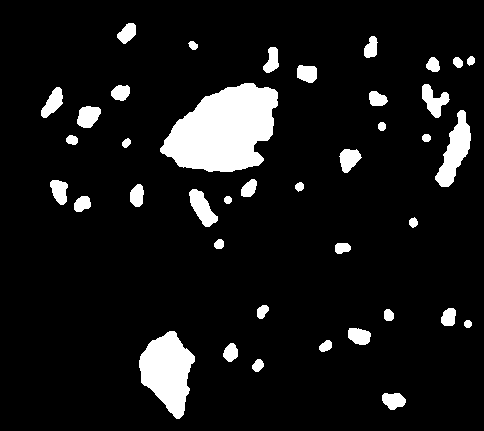

In [6]:
imshow(imgs[1])

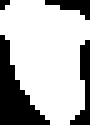

In [7]:
imshow(props[1][1, :mask])

In [8]:
# Day 2
props[2][!, [:uuid, :passtime, :area]]

Row,uuid,passtime,area
,String,DateTime,Int32
1,pAtSEsS6jZrH,2022-09-14T13:59:19,321
2,pUjOGvdbtOXb,2022-09-14T13:59:19,277
3,WKGPO1PTmKbq,2022-09-14T13:59:19,73
4,Tc8smFrVBtT3,2022-09-14T13:59:19,176
5,HR8Jk0ouuBG5,2022-09-14T13:59:19,201
6,oTy0XYhtcthv,2022-09-14T13:59:19,222
7,gVsUhl5WDyKc,2022-09-14T13:59:19,46
8,j8hq8XuP3fAQ,2022-09-14T13:59:19,215
9,XA1wOFQvHTBn,2022-09-14T13:59:19,2899


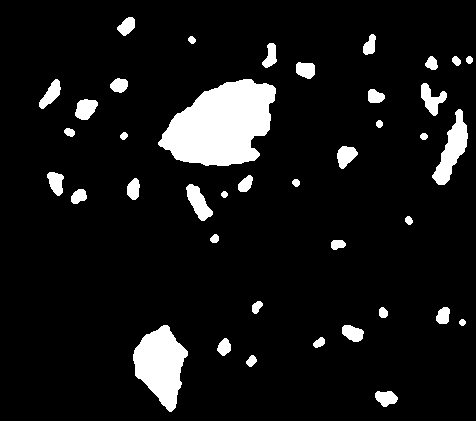

In [9]:
imshow(imgs[2]) # slightly rotated version of the image in day 1

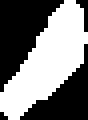

In [10]:
imshow(props[2][1, :mask])

In [11]:
# Day 3
props[3][!, [:uuid, :passtime, :area]]

Row,uuid,passtime,area
,String,DateTime,Int32
1,YhtLlJLpEdpg,2022-09-15T12:44:49,374
2,43nDI6gQMGx0,2022-09-15T12:44:49,320
3,HTZDajz7Qo0f,2022-09-15T12:44:49,94
4,5DvQp7bD6Xug,2022-09-15T12:44:49,208
5,lYaNuyE2IDPs,2022-09-15T12:44:49,395
6,TYZYvMVUDzUm,2022-09-15T12:44:49,236
7,Csj2gMwynzU9,2022-09-15T12:44:49,260
8,eolmUztdnCu0,2022-09-15T12:44:49,63
9,tEzM5ZHBIt3a,2022-09-15T12:44:49,251


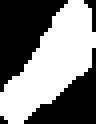

In [12]:
imshow(props[3][1, :mask]) # missing in day 1

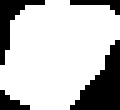

In [13]:
imshow(props[3][5, :mask]) # missing in day 2

### 5. Pair and label floes

In [14]:
# Get paired floes with labels
trajectories = long_tracker(props, condition_thresholds, mc_thresholds);

### 6. View trajectories and _goodness_ of pairings

In [15]:
trajectories[!, [:ID, :passtime, :area_mismatch, :corr]]

Row,ID,passtime,area_mismatch,corr
,Int64,DateTime,Float64?,Float64?
1,1,2022-09-14T12:44:49,missing,missing
2,1,2022-09-14T13:59:19,0.0,0.989722
3,1,2022-09-15T12:44:49,0.0,0.989586
4,2,2022-09-14T12:44:49,missing,missing
5,2,2022-09-14T13:59:19,0.0,0.991565
6,2,2022-09-15T12:44:49,0.0,0.994474
7,3,2022-09-14T12:44:49,missing,missing
8,3,2022-09-14T13:59:19,0.0,0.988498
9,3,2022-09-15T12:44:49,0.0,0.98847


7. Add latitude/longitude data to trajectories

In [16]:
latlonimgpth = joinpath(HOME, "test", "test_inputs", "beaufort-chukchi-seas_truecolor.2020162.aqua.250m.tiff")
addlatlon!(trajectories, latlonimgpth)

In [17]:
# View trajectories with lat/lon data
# Note that the areas are now in physical units (km^2)
cols = [:ID, :area, :passtime, :latitude, :longitude]
trajectories[!, cols]

Row,ID,area,passtime,latitude,longitude
,Int64,Float64,DateTime,Float64,Float64
1,1,31.7219,2022-09-14T12:44:49,65.4586,-172.087
2,1,27.3962,2022-09-14T13:59:19,65.4537,-172.085
3,1,31.7219,2022-09-15T12:44:49,65.4736,-172.067
4,2,199.442,2022-09-14T12:44:49,65.3314,-170.047
5,2,190.004,2022-09-14T13:59:19,65.3107,-170.052
6,2,199.507,2022-09-15T12:44:49,65.3183,-170.045
7,3,37.8828,2022-09-14T12:44:49,65.1822,-170.872
8,3,33.6226,2022-09-14T13:59:19,65.167,-170.886
9,3,37.8828,2022-09-15T12:44:49,65.1809,-170.877


In [18]:
grouped_trajectories = groupby(trajectories, :ID);

,,

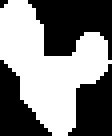
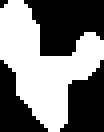
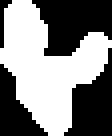

In [19]:
imshow.(grouped_trajectories[1].mask)

,,

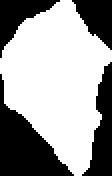
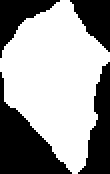
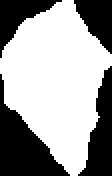

In [20]:
imshow.(grouped_trajectories[2].mask)

,,

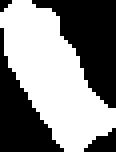
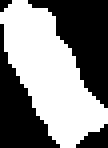
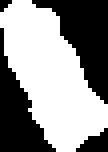

In [21]:
imshow.(grouped_trajectories[3].mask)

,,

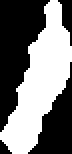
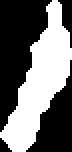
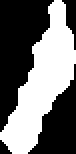

In [22]:
imshow.(grouped_trajectories[4].mask)

,,

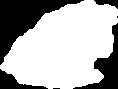
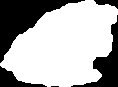
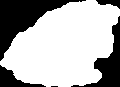

In [23]:
imshow.(grouped_trajectories[5].mask)